In [21]:

import torch
import torch.nn as nn


import torchvision
import torchvision.transforms as transforms

import os


from model import *


from collections import OrderedDict
import pickle


device = 'cuda' if torch.cuda.is_available() else 'cpu'


class CustomDataset(torch.utils.data.Dataset):
  
    def __init__(self, imgs, labels, transform=None):
        """
        Arguments:
            
        """
        self.images = imgs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = self.images[idx,:]
        if self.transform:
            image = self.transform(image)
        image = torch.tensor(image)
        label = torch.tensor(self.labels[idx])
        return image,label




transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = './data_course/cifar-10-python/cifar-10-batches-py'



# Load test batch
test_batch = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
test_images = test_batch[b'data']
test_images = test_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

test_labels = test_batch[b'labels']


test_dataset = CustomDataset(test_images, test_labels,transform= transform_test)
testloader_course = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=16)

testset_original = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader_original = torch.utils.data.DataLoader(
    testset_original, batch_size=100, shuffle=False, num_workers=2)


# Model


def ResNet18():
    return ResNet(BasicBlock, [2, 1, 1, 1])

net = ResNet18()



net = net.to(device)
state_dict = torch.load("files/saved_model.pth",map_location=device)
if device == 'cuda':
    net.net.load_state_dict(state_dict)

else:
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        if 'module' in k:
            k = k[7:]
        new_state_dict[k]=v
    net.load_state_dict(new_state_dict)

criterion = nn.CrossEntropyLoss()


def test(test_loader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    y_test = []
    predictions = []
    with torch.no_grad():
        for _, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            y_test.extend(targets)
            predictions.extend(predicted)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print('TestLoss: %.3f | TestAcc: %.3f%% (%d/%d)'% (test_loss/len(test_loader), 100.*correct/total, correct, total))
    return y_test, predictions


y_test, predictions =test(test_loader=testloader_original)


    

Files already downloaded and verified
TestLoss: 0.225 | TestAcc: 93.970% (9397/10000)


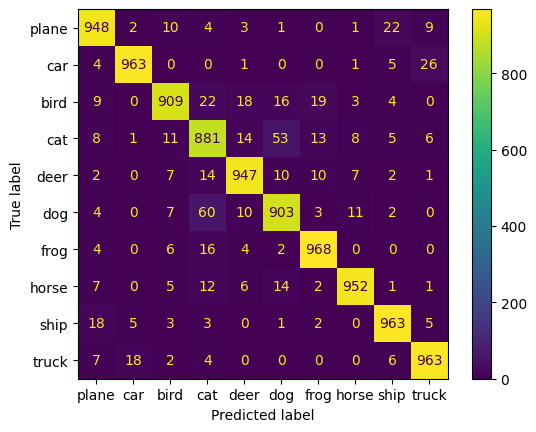

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
target_names = ['plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(y_test, predictions )
ConfusionMatrixDisplay(cm, display_labels=target_names).plot()

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,target_names=target_names ))


              precision    recall  f1-score   support

       plane       0.94      0.95      0.94      1000
         car       0.97      0.96      0.97      1000
        bird       0.95      0.91      0.93      1000
         cat       0.87      0.88      0.87      1000
        deer       0.94      0.95      0.95      1000
         dog       0.90      0.90      0.90      1000
        frog       0.95      0.97      0.96      1000
       horse       0.97      0.95      0.96      1000
        ship       0.95      0.96      0.96      1000
       truck       0.95      0.96      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



# Model Summary


In [14]:
from torchsummary import summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,